Problem

Kekhawatiran adanya keterlambatan pembayaran kartu kredit pada FinanKu yang akan merugikan bisnis sehingga orang-orang yang memiliki potensi untuk mengalami keterlambatan bayar dapat diprediksi lebih cepat dengan cara menentukan strategi yang sesuai dalam menghadapi kondisi di masa yang akan datang.

Objective

Membuat sebuah model yang dapat memprediksi setidaknya 60% dari pelanggan yang akan mengalami telat bayar kartu kredit (Accuracy dan Recall > 60%).

Variable

- Customer ID: unique ID customer.
- Branch: lokasi cabang nasabah terdaftar.
- City: lokasi kota nasabah terdaftar.
- Age: umur nasabah pada periode observasi.
- Avg. Annual Income: rata-rata penghasilan nasabah dalam satu tahun.
- Balance (Q1-Q4): saldo mengendap yang dimiliki nasabah di akhir kuartal.
- Num of Product (Q1-Q4): jumlah kepemilikan produk nasabah yang dimiliki di akhir kuartal.
- HasCrCard (Q1-Q4): status kepemilikan produk kartu kredit nasabah di akhir kuartal.
- Active Member (Q1-Q4): status keaktifan nasabah.
- Unpaid tagging: status nasabah gagal bayar.

Experiment

Periode tinjauan:
- Nasabah di-review selama satu tahun terakhir.
- Nasabah di-review selama 6 bulan terakhir.

Penyesuaian variabel:
- Balance dilihat dari rata-rata selama horizon waktu dan dilihat perubahan pada akhir tinjauan dan awal tinjauan.
- Melihat kepemilikan jumlah produk dari rata-rata, maksimum, dan minimum pada periode tinjauan.
- Status keaktifan nasabah dilihat dalam bentuk bulan.

Import Package

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from jcopml.feature_importance import mean_score_decrease

In [10]:
pd.set_option('display.max_columns', None)

Import Data

In [11]:
path_1 = "FinanKu Data All.csv"
path_2 = "FinanKu Data Validasi.csv"
df_all = pd.read_csv(path_1)
df_val = pd.read_csv(path_2)

Data Eksperimen 1

In [12]:
df1 = pd.read_csv(path_1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


Data Eksperimen 2

In [6]:
df2 = pd.read_csv(path_1)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,...,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,...,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,...,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,...,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,...,0,678905.68,2,1,1,431190.68,2,1,1,0


Data Understanding

Sebaran Nasabah Berdasarkan Lokasi
- Sebaran Keseluruhan
- Sebaran Nasabah Gagal Bayar

In [14]:
data1 = pd.DataFrame(
    df_all.groupby(by=['City'])['Customer ID'].count().sort_values(ascending=False).reset_index(name='Sebaran Berdasarkan Kota')
)

data1

,City,Sebaran Berdasarkan Kota
0,Surabaya,3767
1,Bandung,1898
2,Jakarta,1896


In [19]:
data2 = pd.DataFrame(
    df_all[df_all['Unpaid Tagging']==1].groupby(by=['City'])['Customer ID'].count().sort_values(ascending=False).reset_index(name='Sebaran Berdasarkan Kota')
)

data2

,City,Sebaran Berdasarkan Kota
0,Surabaya,1033
1,Bandung,496
2,Jakarta,490


Sebaran Nasabah Berdasarkan Usia
- Sebaran Keseluruhan
- Sebaran Nasabah Gagal Bayar

In [ ]:
# Data Kolom

data3 = pd.DataFrame(
    df_all.groupby(by=['Age'])['Customer ID'].count().reset_index(name='Sebaran Keseluruhan Usia')
)

data3.sort_values(by='Age',ascending=True)

data3

,Age,Sebaran Keseluruhan Usia
0,22,163
1,23,145
2,24,181
3,25,146
4,26,158
5,27,156
6,28,151
7,29,168
8,30,162
9,31,135


<Axes: title={'center': 'Cust. Distriibution By Age'}, xlabel='Age', ylabel='People'>

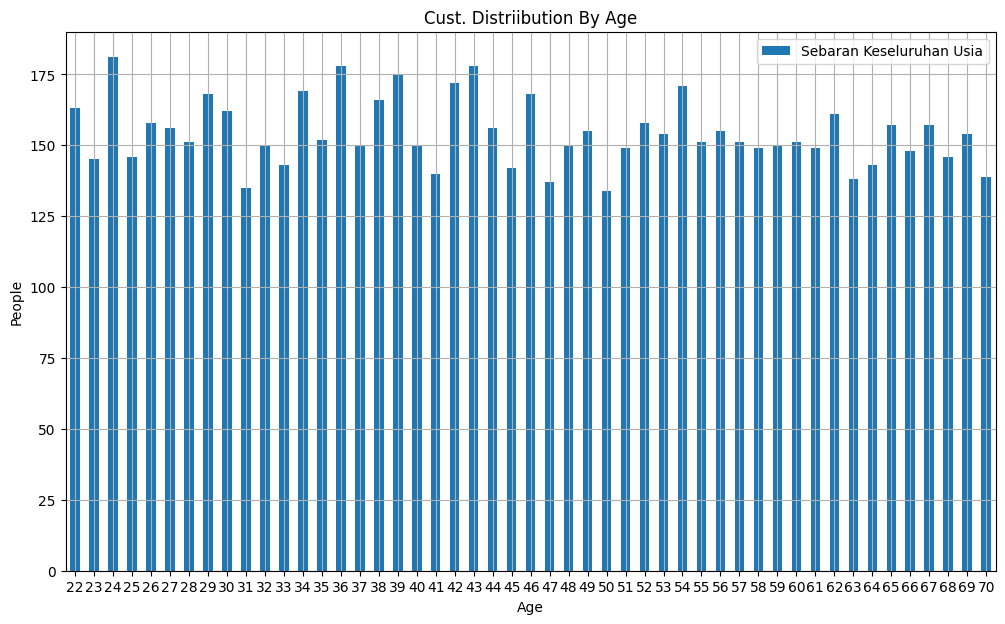

In [ ]:
# Data3 Visualisasi

data3.plot(
    x = 'Age',
    y = ['Sebaran Keseluruhan Usia'],
    kind = 'bar',
    grid = True,
    xlabel = 'Age',
    ylabel = 'People',
    figsize=(12,7),
    rot=0,
    title='Cust. Distribution By Age',
    table=False
)

In [28]:
# Sebaran Nasabah Gagal Bayar Berdasarkan Usia

data4 = pd.DataFrame(
    df_all[df_all['Unpaid Tagging']==1].groupby(by=['Age'])['Customer ID'].count().reset_index(name='Sebaran Usia Gagal Bayar')
)

data4.sort_values(
    by='Age', ascending=True
)

data4

,Age,Sebaran Usia Gagal Bayar
0,22,34
1,23,48
2,24,57
3,25,31
4,26,36
5,27,47
6,28,43
7,29,36
8,30,40
9,31,27


<Axes: title={'center': 'Cust. Unpaid Tag Distribution By Age'}, xlabel='Age', ylabel='Unpaid Tag'>

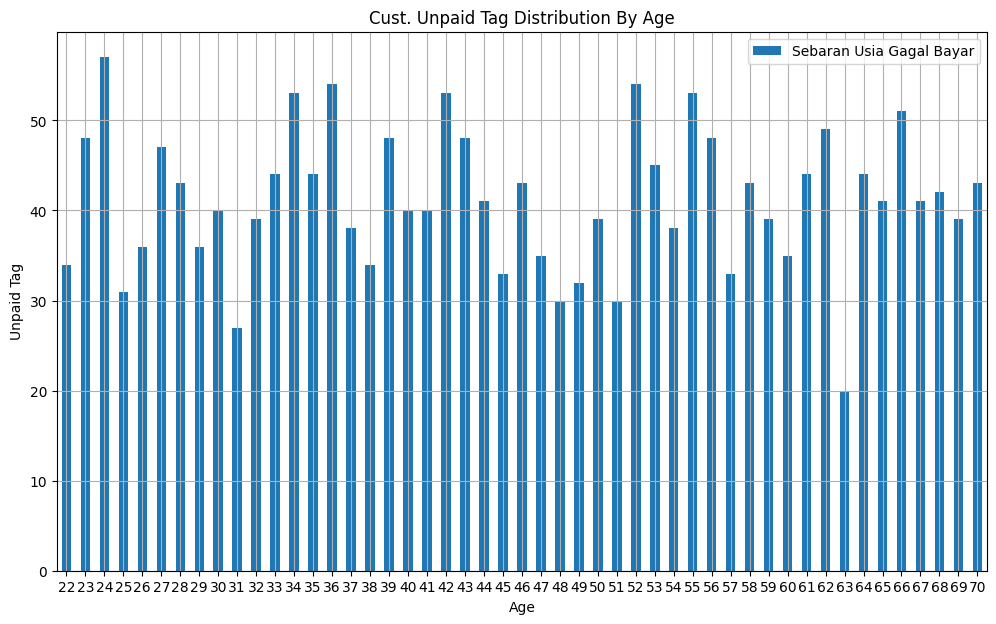

In [32]:
# Visualisasi Data4

data4.plot(
    x='Age',
    y='Sebaran Usia Gagal Bayar',
    kind='bar',
    grid=True,
    xlabel = 'Age',
    ylabel = 'Unpaid Tag',
    figsize=(12,7),
    rot=0,
    title='Cust. Unpaid Tag Distribution By Age',
    table=False
)